In [1]:
import pandas as pd
import numpy as np
import glob
import base64
import matplotlib.pyplot as plt
import os

from PIL import Image
from io import BytesIO
from IPython.display import HTML
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


## Dataset: Dog Breed Identification

In [2]:
lbl = pd.read_csv('labels.csv')
lbl.breed.value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
cairn                             106
leonberg                          106
beagle                            105
japanese_spaniel                  105
blenheim_spaniel                  102
australian_terrier                102
miniature_pinscher                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
whippet                            95
siberian_husky                     95
norwegian_elkhound                 95
pug         

In [3]:
pd.set_option('display.max_colwidth', -1)


def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def get_full(path):
    i = Image.open(path)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

## Class 1: Afghan Hound

,breed,thumbnail
9530,afghan_hound,
5198,afghan_hound,
4093,afghan_hound,
1692,afghan_hound,
4775,afghan_hound,
3772,afghan_hound,
8912,afghan_hound,
5136,afghan_hound,
9142,afghan_hound,
3497,afghan_hound,

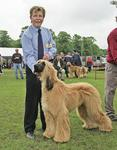
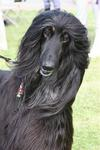
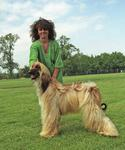
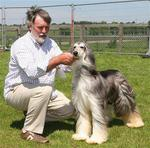
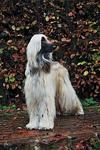
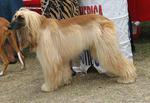
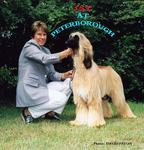
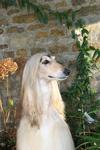
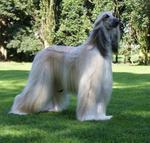
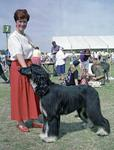

In [4]:
dogz = pd.read_csv('labels.csv')
dogs = dogz[dogz.breed=='afghan_hound'].copy().sample(10)
dogs['file'] = dogs.id.map(lambda id: f'./train/{id}.jpg')
dogs['thumbnail'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs['image'] = dogs.file.map(lambda f: get_full(f))
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'thumbnail']].to_html(formatters={'thumbnail': image_formatter}, escape=False))

## Class 2: Entlebucher

,breed,thumbnail
6861,entlebucher,
6116,entlebucher,
9790,entlebucher,
7856,entlebucher,
8897,entlebucher,
7855,entlebucher,
488,entlebucher,
1883,entlebucher,
4870,entlebucher,
4383,entlebucher,

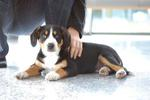
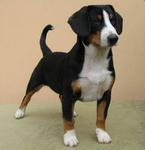
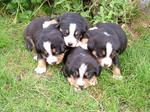
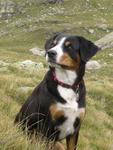
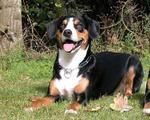
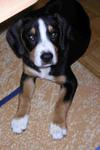
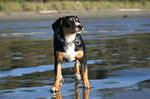
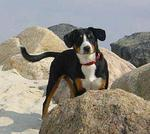
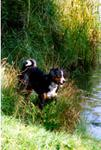
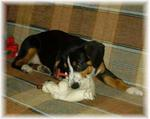

In [5]:
dogs = dogz[dogz.breed=='entlebucher'].copy().sample(10)
dogs['file'] = dogs.id.map(lambda id: f'./train/{id}.jpg')
dogs['thumbnail'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs['image'] = dogs.file.map(lambda f: get_full(f))
# displaying PIL.Image objects embedded in dataframe
HTML(dogs[['breed', 'thumbnail']].to_html(formatters={'thumbnail': image_formatter}, escape=False))

## Data Preparation

In [6]:
desired_dogs = dogz[(dogz.breed=='entlebucher') | (dogz.breed=='afghan_hound')].copy()
dogs = pd.DataFrame(index=[0])
for row in desired_dogs.index:
    new_ind = len(dogs)
    id_ = desired_dogs['id'].loc[row]
    breed = desired_dogs['breed'].loc[row]
    #I hand-cropped some images to include only dog faces
    #and set all images to 64x64 pixels.
    try:
        img = Image.open(f'./bindogs/faces/resize/{id_}.bmp')
    except:
        img = None
    if img != None:
        new_row = pd.DataFrame(index=[new_ind])
        new_row['id'] = id_
        new_row['breed'] = breed
        new_row['image'] = [img]
        dogs = pd.concat([dogs, new_row], axis=0)
        
dogs = dogs.loc[1:].copy()

## Cropped/Reformatted Images

,breed,image
22,entlebucher,
75,afghan_hound,
52,afghan_hound,
27,entlebucher,
67,afghan_hound,
82,afghan_hound,
47,entlebucher,
25,afghan_hound,
28,afghan_hound,
95,entlebucher,

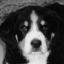
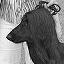
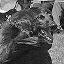
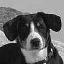
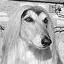
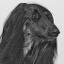
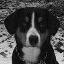
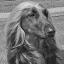
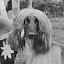
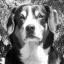

In [7]:
HTML(dogs[['breed', 'image']].sample(10).to_html(formatters={'image': image_formatter}, escape=False))

## Convert to Binary (black/white only) Images

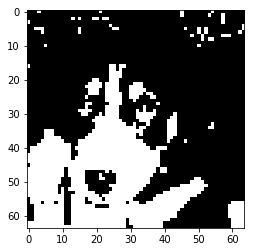

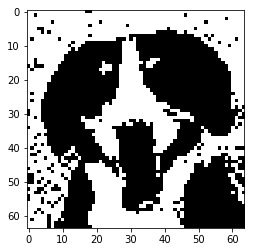

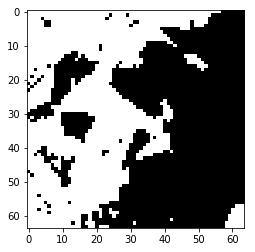

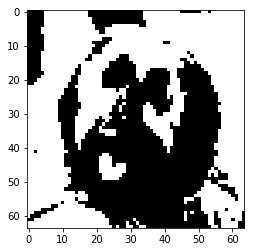

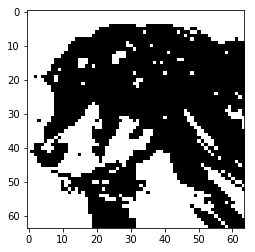

In [8]:
def to_bw(image_array):
    mn = image_array.mean()
    result = (image_array < mn)
    return np.where(result, 1, 0)

def invert_array(arr):
    mx = arr.max()
    result = mx - arr
    return result

dogs['binary'] = dogs.image.apply(lambda x: to_bw(np.asarray(x)))
#dogs['binary'] = dogs.image.apply(lambda x: invert_array(np.asarray(x)))
cnt = 0
for row in dogs.index:
    disp = dogs.loc[row]['binary']
    plt.imshow(disp, cmap='Greys');
    plt.show();
    cnt += 1
    if cnt > 4:
        break

## Feature Extraction

In [9]:
#Nudging to increase sample size
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 64x64 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((64, 64)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


    shift = lambda x, w: convolve(x, mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

X_ = np.array([np.asarray(x).reshape(4096) for x in dogs.binary])
Y_ = np.asarray(dogs.breed)
X, Y = nudge_dataset(X_, Y_)

## Run RBM

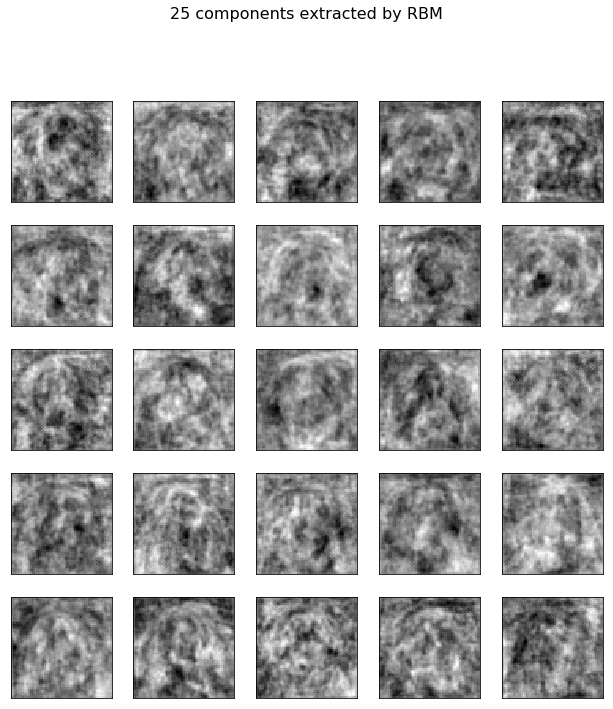

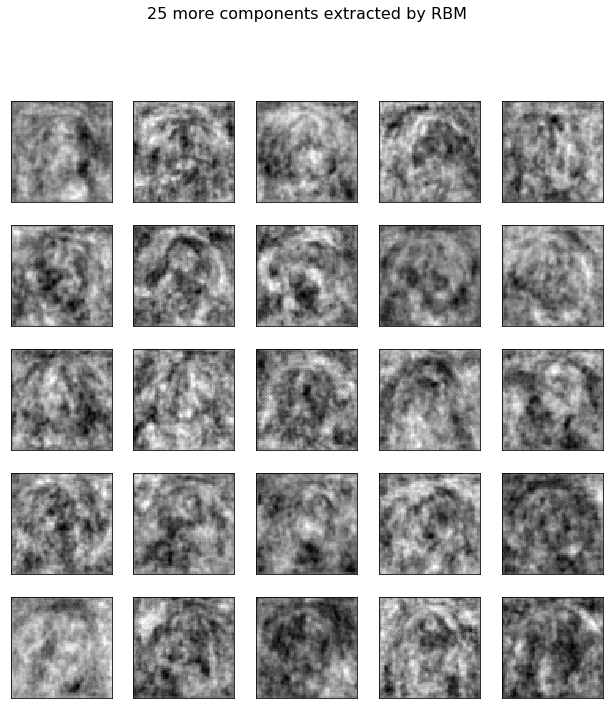

In [10]:
rbm1 = BernoulliRBM(
    random_state=0, 
    verbose=False,
    learning_rate = 0.005,
    n_iter = 300,
    n_components = 100
)

rbm1.fit(X, Y)

plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm1.components_[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('25 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm1.components_[25:50]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('25 more components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## Test with SVC

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_,
                                                    test_size=0.2,
                                                    random_state=0)

X_train, Y_train = nudge_dataset(X_train, Y_train)
X_test, Y_test = nudge_dataset(X_test, Y_test)

svc = SVC()
rbm = BernoulliRBM(random_state=0, verbose=False)

classifier = Pipeline(steps=[('rbm', rbm), ('svc', svc)])

rbm.learning_rate = 0.005
rbm.n_iter = 300
rbm.n_components = 100

classifier.fit(X_train, Y_train)

svclassifier = SVC()
svclassifier.fit(X_train, Y_train)

#Evaluation

print()
print("SVC using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        classifier.predict(X_test))))

print("SVC using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        svclassifier.predict(X_test))))


SVC using RBM features:
              precision    recall  f1-score   support

afghan_hound       0.94      0.94      0.94        50
 entlebucher       0.93      0.93      0.93        45

 avg / total       0.94      0.94      0.94        95


SVC using raw pixel features:
              precision    recall  f1-score   support

afghan_hound       0.90      0.94      0.92        50
 entlebucher       0.93      0.89      0.91        45

 avg / total       0.92      0.92      0.92        95


